# OVERVIEW

All three figures and corresponding outputs support the general conclusions of Reich et al. (2021). Our PCA broadly separated groups by coral host taxa rather than sampling location, the phylogeny grouped out by host, and the selction analysis yielded outliers on the same order of magnitude as that of the paper. However, the conclusions of our outputs are not as strong as those in the paper. There was more overlap in the PCA between groups, and there were weaker bootstrap values in the phylogeny, especially at the base of the tree. In addition, *A. cervicornis* symbionts were not monophyletic (as they were in the Reich et al. analysis). Both of our analyses for outliers identified more SNPs than in the original paper. 

After trying to replicate the methods in Reich et al. (2021), we feel that a paper's reproducibility depends heavily on the audience. There were aspects of the authors' methods and documentation that may have been clear to the authors or someone familiar with their field, but were confusing for us. The lack of a pipeline (either as a figure or scripted) also created significant opportunity for divergence. There were multiple places in the analyses where we had to make assumptions or even guesses to continue, which likely contributed greatly to the final differences that we report below.

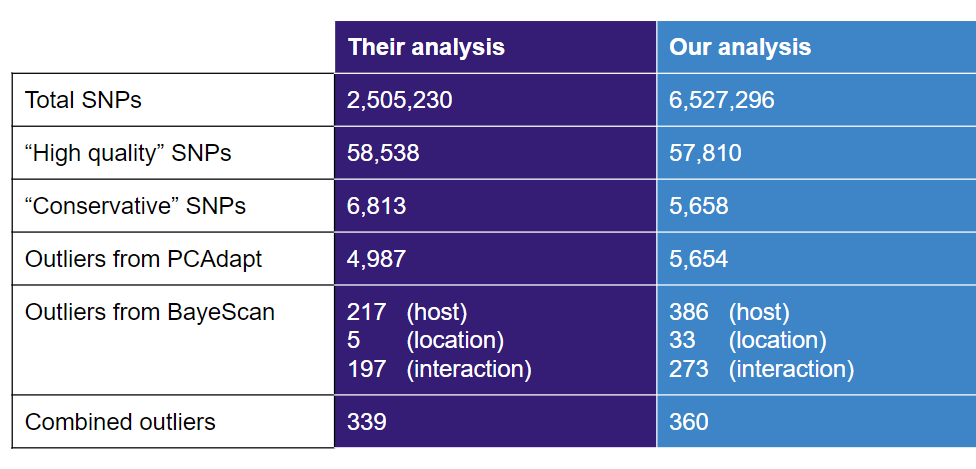

In [1]:
library("IRdisplay")
display_png(file="../figures/dino_popgen_summary_table.png")

### Table 1:
**SNP counts from the author's analyses (dark blue) and ours (light blue), highlighting the impact our slightly different analyses had on the outcome.** 

# ANALYSES

## Principal Component Analysis

Conducting the principal component analysis (PCA) was relatively simple and straightforward, and this is reflected in how closely the recreated figure matches the original. The authors uploaded to github the RMarkdown file they used to create the figure, including the majority of figure 'polishing' to make it publication-ready, and I was able to copy the entire script and run it on my personal computer in RStudio. The script started with output from previous steps, with no file conversion necessary, and most of the code ran as-is. 

The biggest issues I ran into fell into 2 categories: i) certain steps were originally conducted manually, and therefore I had to be careful about ensuring that my code and files matched the *intention* of the orginials (which involved some inference); and ii) certain packages and functions were updated since the paper came out, and package versions were mostly not defined in the paper or code, so some functions returned warnings and others would not work until I modified it. The most notable examples include:

* I had to re-format the metadata file, so that the point colors and shapes were correctly assigned
* I had to re-assign the metadata columns, because they were originally assigned by column number (which obviously differed between the authors' file and mine)
* I had to manually edit the axis labels and title, to match my output -- these were not coded in
* Several aspects of ggplot required tweaking for the plot to work: moving and combining aesthetic arguments, tweaking variable names to match the metadata file
* One package (vcfR) was missing from the document, but it was listed elsewhere and so was not difficult to find

I chalk up the ggplot issues to versioning, and I recognize why aspects of the plot (e.g., percent variance in the axis labels and number of SNPs in the title) were entered manually, but it was notable how much time it took to make all of the necessary tweaks. In terms of reproducibility, my biggest issue was with the reformatting and re-assignment for the meta-data file; these steps were missing from the authors' published code, which meant that I had to 1) notice that my initial plot looked off, and 2) figure out how to match the metadata sample order to that in the vcf (output) file.

As far as the reproducibility of the results themselves, I would argue that the conclusions of the paper hold up well. We conducted the re-anlaysis with 47 of the original 49 sequences, and we ended up with ~700 fewer SNPS (out of 58,000). The first and second principal components (PC1 and PC2) explain about the same amount of variance in both plots (PC1: 15.7% vs 16%; PC2: 12.2% vs 13.6%). Most importantly, the points cluster by host taxon in both plots, though there is more overlap in my recreation than in the original figure. We suspect this overlap may be caused by a few factors: 1) we omitted the 2 largest sequences for reasons of HPC storage space, which may have lost us substantial information; and 2) we suspect that our pipeline may not have fully removed all non-variant sites, which would cause the samples to look more similar to one another than in the original analysis (when variants were, presumably, successfully isolated). Overall, we conclude that the PCA and its findings were fairly robust to reanalysis.

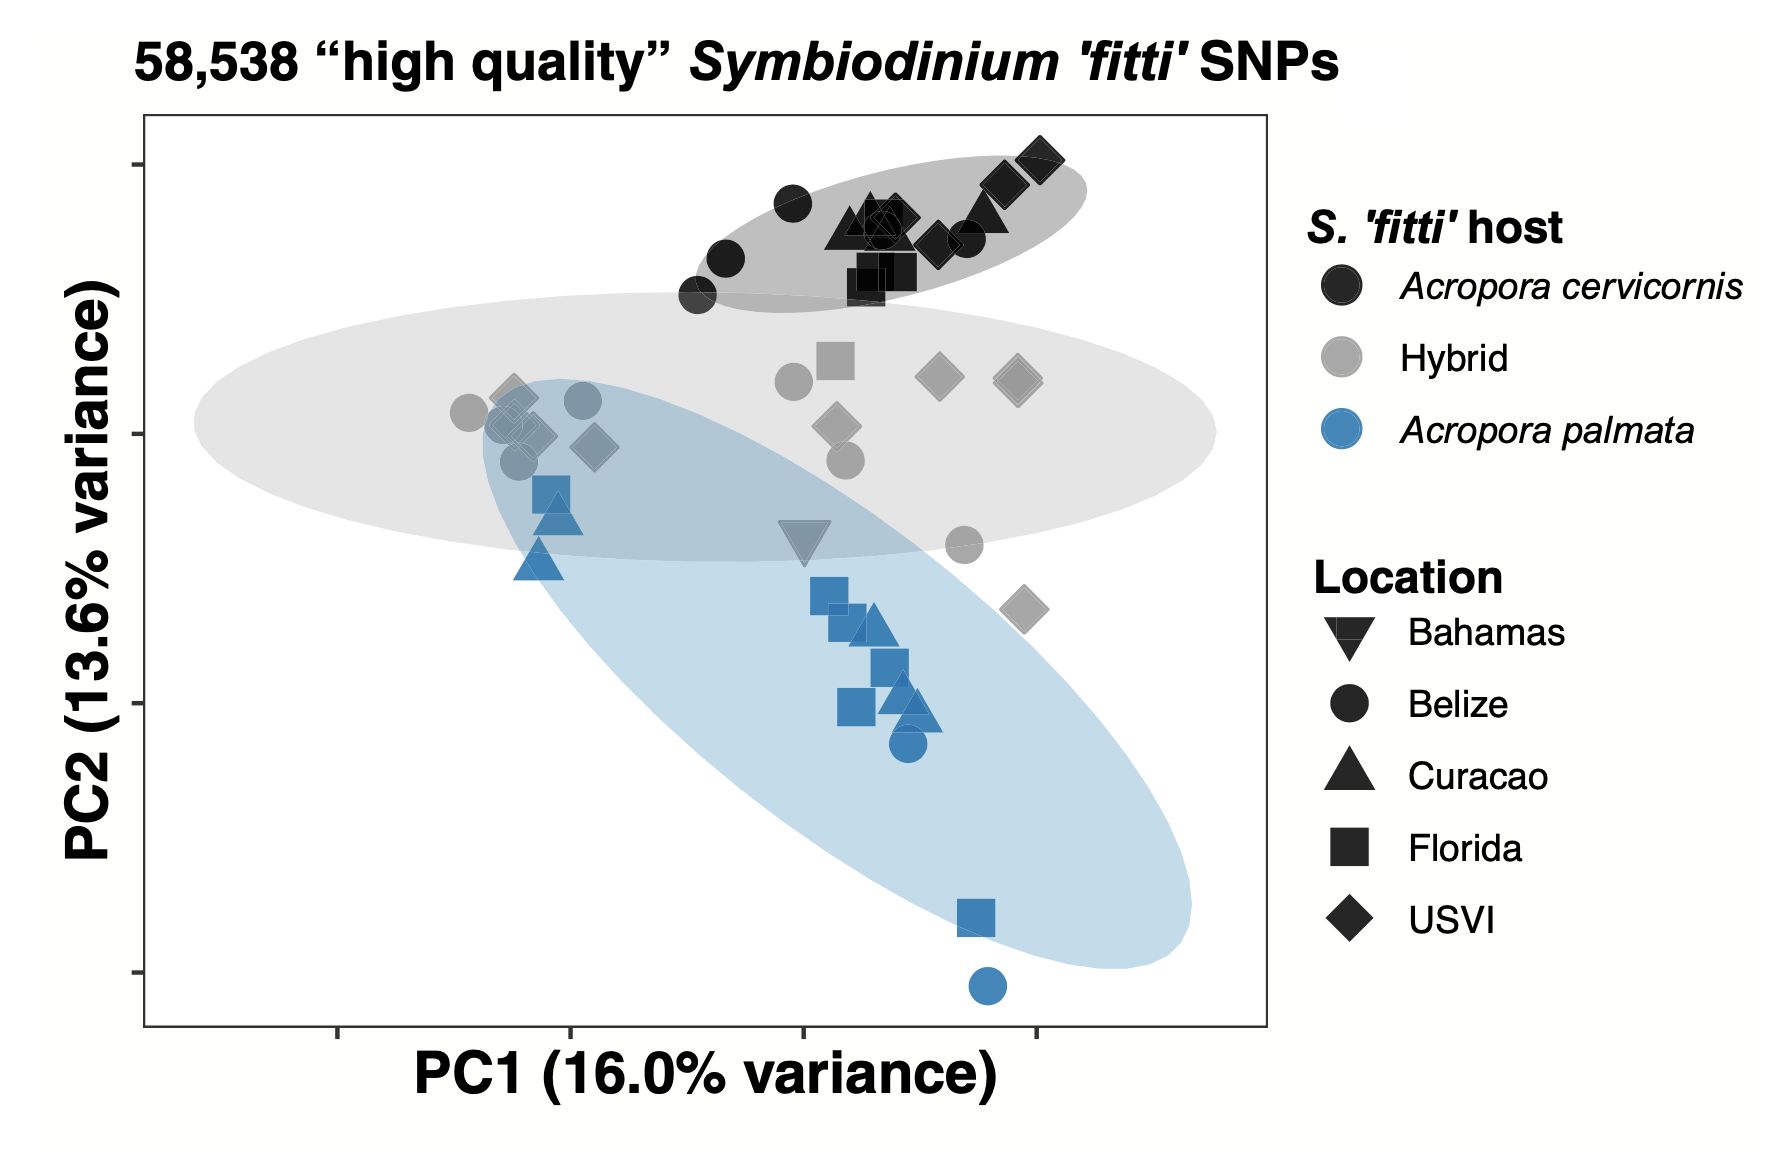

In [2]:
display_png(file="../figures/Fig2_original_Reich2021.png", height = 300, width = 400)

### Figure 2 from Reich et al. (2021):
**Principal component analysis for high quality SNP data, with point color corresponding to host coral and point shape corresponding to coral location. Shaded ovals represent 95% confidence intervals for coral-specific groups. The original paper emphasizes the entent to which genetic differentiation clusters by coral host.**

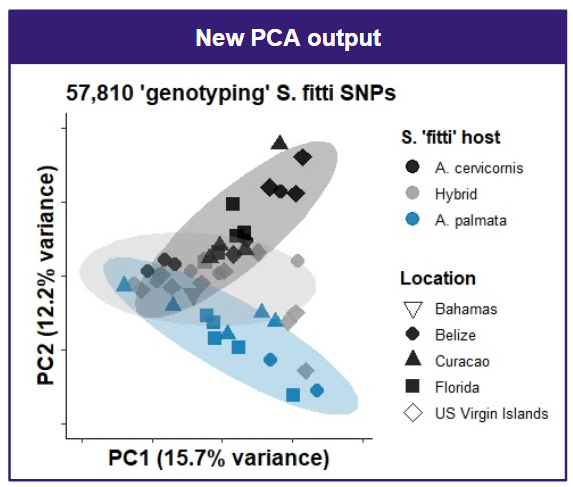

In [3]:
display_png(file='../figures/Fig2_JBW.png', height = 300, width = 400)

### Re-created figure 2
**PCA of same data, excluding 2 largest sequences (and, by extension, ~700 fewer SNPs). Percent variance explained by PC1 and PC2 were extremely similar to values in published figure, and the grouping by host taxon was consistent between original and re-created figures (with, however, increased overlap in re-created figure, likely due to exclusion of 2 sequences and/or pipeline issues). Symbology identical to previous figure. Note: y-axis had to be flipped in order for spatial layout to match original figure.**

## Phylogeny

Creating the phylogeny, while seemingly simple, ended up being an incredibly challenging process due to one huge roadblock...the step for transitioning from variant calls to multiple sequence alignment was not detailed in the manuscript or paper github, so we had to identify our own method for this. The package we ultimately used, vcfkit, was one of the only straightforward tools found online to achieve this, but was (for some reason) impossible to install on the HPC initially (days-long “Solving Environment” message, glibc error, etc.). Several other approaches were identified, but all proved unhelpful for various reasons:

* vcflib – Required individual-sample vcf files, output logfiles were all blank and unhelpful for troubleshooting. (https://github.com/vcflib/vcflib)  
* vcf2msa – This was a wrapper file downloaded from github, ran in python but also yielded bugs and incomplete documentation made it challenging to troubleshoot. (https://github.com/tkchafin/vcf2msa.py)  
* gatk4 – This approach was the most promising, as the FastaAlternateReferenceMaker function can take a vcf and create a fasta sequence for alignment. However, this approach required the final vcf to be split into individual sample vcfs and indexed. Significant time was spent getting gatk to work (initial installation trouble, then loaded the gatk module directly from HPC, then realized that we actually needed gatk4 to access   FastaAlternateReferenceMaker which needed to be downloaded from bioconda). While we were able to generate final fasta files for each sample using this approach, the resulting files used the entire original reference, making them millions of base pairs long and not appropriate for use in alignment.
* vcftools consensus – Similar to gatk, this output was not actually what we were looking for.

Ultimately, vcfkit was installed successfully by an alternate HPC user (shoutout to Cory Berger!) and the phylo function was used to create the fasta file for alignment.

Filtering for sites with no missing data (100% coverage across samples) yielded 5,568 high-quality SNPs; this is 18% less than the 6,813 conservative SNPs identified in the paper. The reduction in total SNPs identified could be an artifact from leaving large/deep sequences out of the analysis, or it could be a result of an inconsistency in variant calling (see additional discussion below).  Similar to the PCA analysis, symbionts clustered phylogenetically based on coral host rather than sample location, with hybrid symbionts grouped in between A. cervicornis and A. palmata symbionts. However, we found that bootstrap values were much weaker in the reproduced analysis. The original paper had 16 branches with bootstrap support values >50, whereas our final analysis had only 4 branches that were supported at >50. Of these, the highest bootstrap support value was 86, compared to 100 in the manuscript. Furthermore, our most confident bootstrap values were placed farther out along the branches, there is less support for differentiation at the base of the unrooted tree.¬ A major finding of the phylogeny analysis in the original paper was that A. cervicornis symbionts were monophyletic, this was not observed in the reanalysis.

A concerning result, noticed in the fasta alignment of the sample sequences (vcfkit output), is that not all aligned nucleotides appear to actually be SNPs. There are many locations where all samples have the same nucleotide called. Looking back through our code and comparing our variant counts with the manuscript, it appears that the divergence which caused this issue may have occurred in the bcftools view step, although we used all flags and parameters outlined in the paper/github. If we were to rerun the analysis again, we would want to set stricter filters for SNPs (likely using a different program such as GATK) and validate that they were accurately called. This hiccup in analysis likely explains some of the divergence between expected and reproduced results.

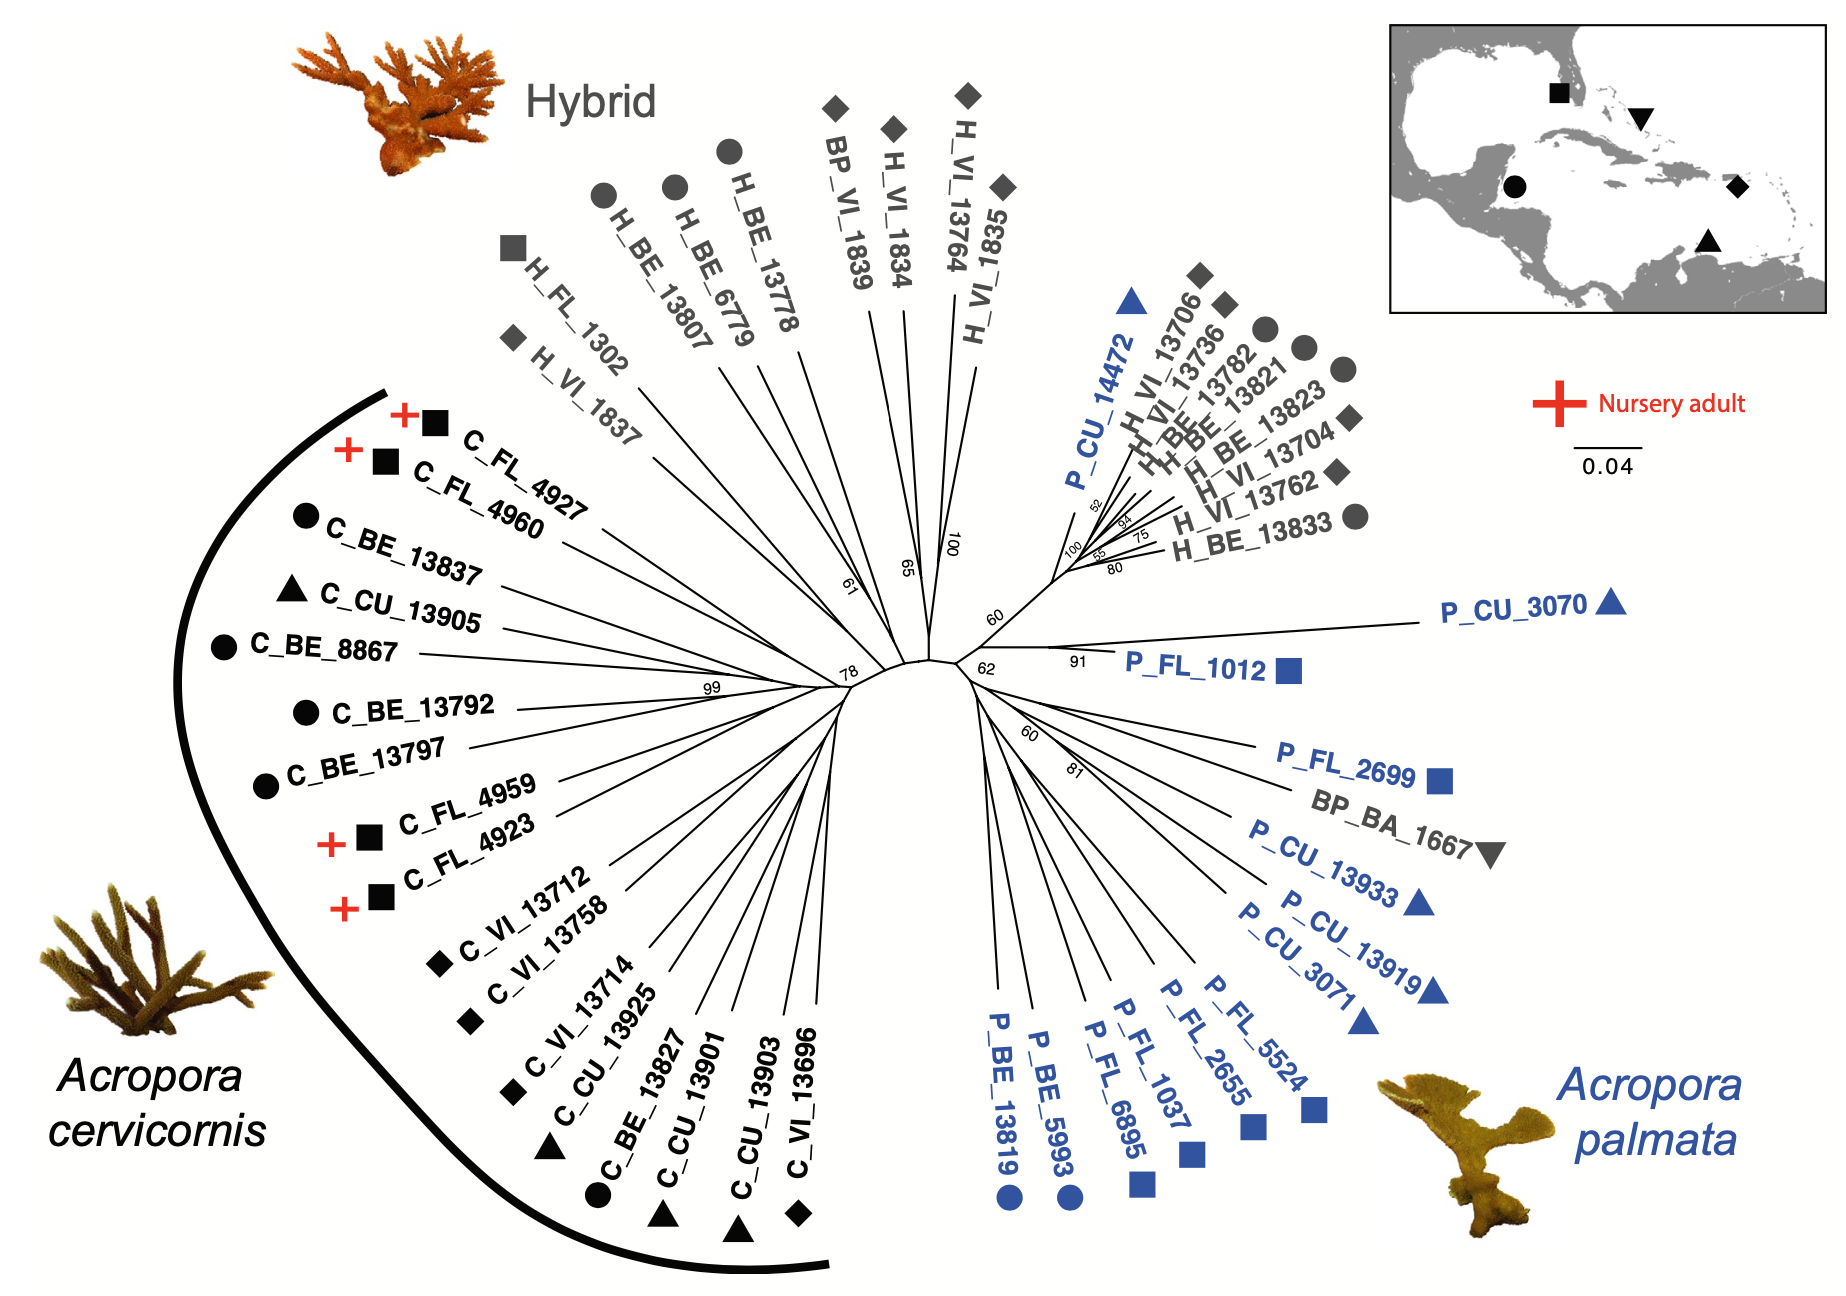

In [4]:
# original phylogeny
display_png(file="../figures/Fig3_original_Reich2021.png")

### Figure 3 from the paper
**This is the phylogeny taken directly from Reich et al, the phylogeny was visualized in iTOL, but based in the formatting it appears that annotation and colors/symbols were added manually. Color indicates host taxa _(A. cervicornis, A. palmata,_ or hybrid) and symbol indicates sample origin. Only bootstrap values >50 are displayed.**

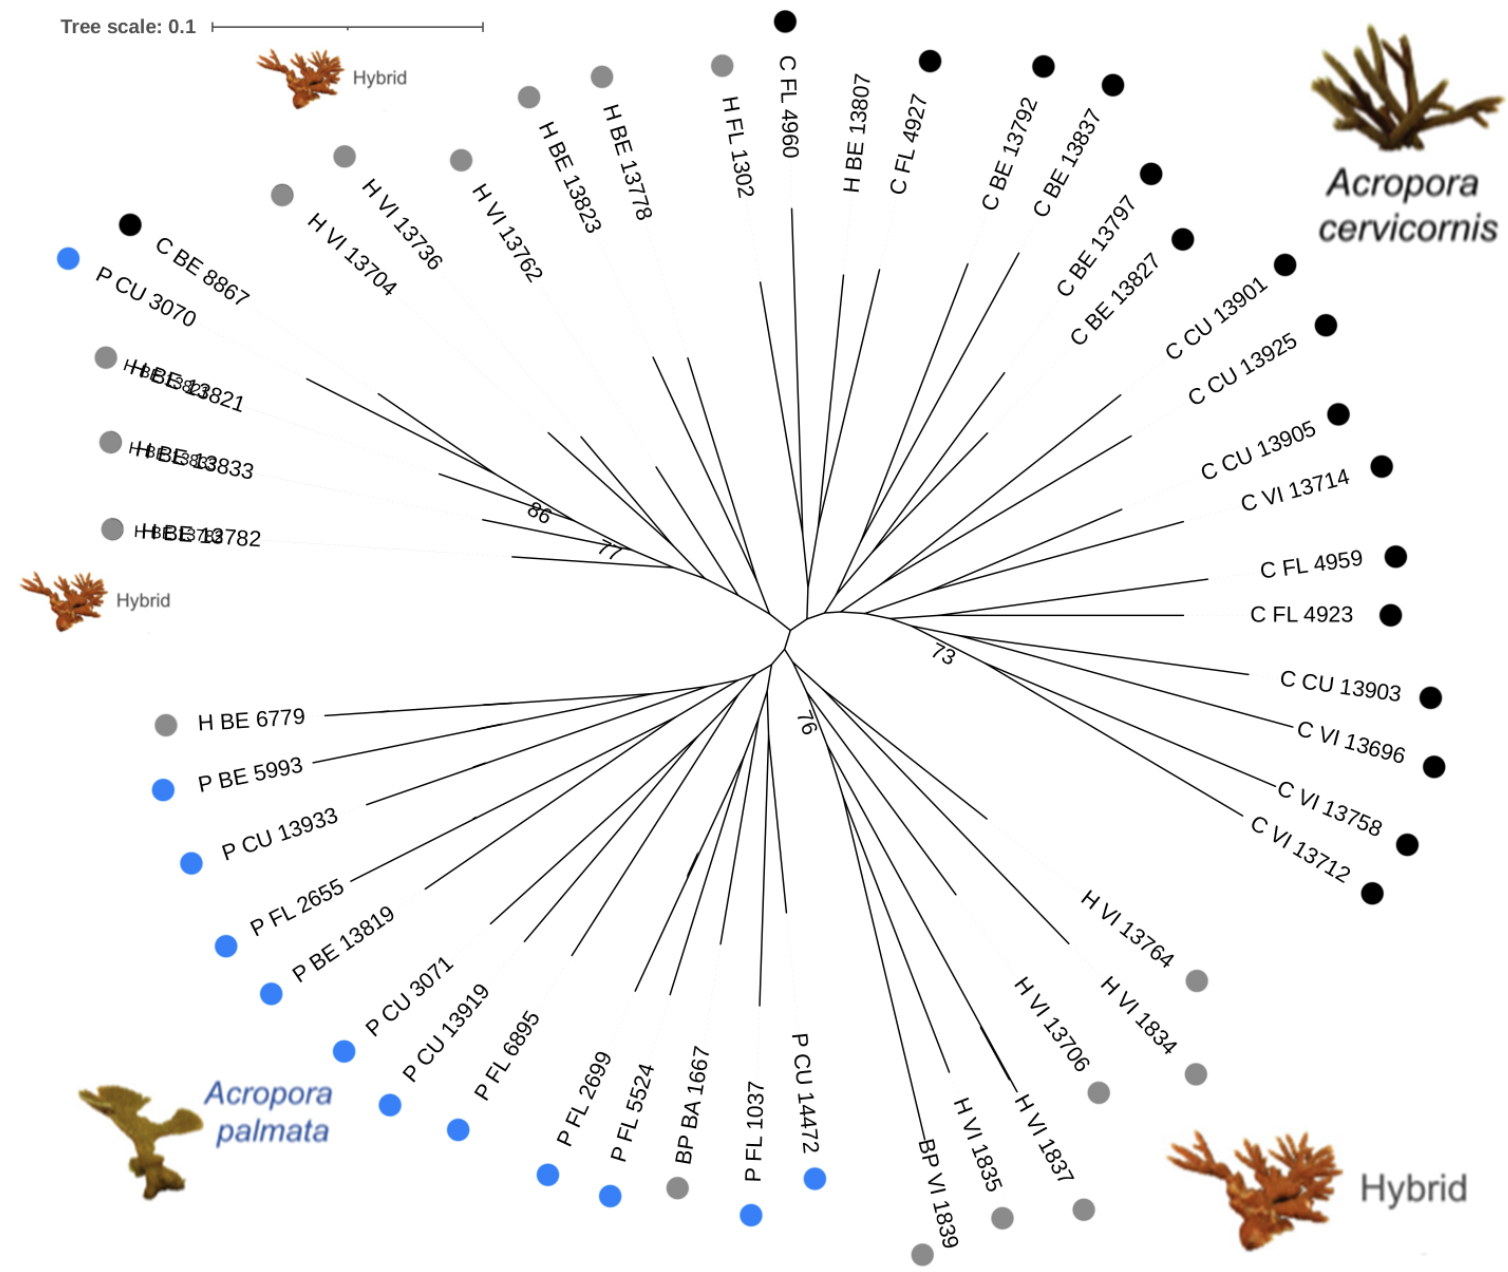

In [11]:
display_png(file="../figures/Fig3_phylogeny_EF_edit.png")

### Figure 3 Reproduced
**This is the best tree identified by RAxML-NG and visualized online with iTOL. Code for creation are located in /scripts/phylogeny and in /jupyter/figure-3_EF.ipynb.**

## Selection

Outliers were identified using two different programs: BayeScan 2.1 and PCAdapt 4.3.3. This was the version of BayeScan used in the paper, however PCAdapt 4.0.3 was used in the paper. Between possible errors in the linux download of 4.0.3 and the availability of 4.3.3 on bioconda, we opted to use 4.3.3.

### *PCAdapt*
PCAdapt was very straightforward between the documentation in the methods and the R script on github. When our .vcf file was plugged into the PCAdapt R code, it produced 5,654 SNPs under selection, compared to 4,987 determined in the paper. Because we removed deep sequenced file from our dataset, PCAdapt may have identified SNP outliers that would not have been identified if that deep sequenced sample was in the analysis. However, the SNPs under selection reported by PCAdapt were relatively similar despite the differences in processing that may have arisen between the two analyses.

### *BayeScan*
The outlier analysis using BayeScan proved to be more difficult. Although information was provided in the paper (version numbers, default settings) and the code was provided for the actual analysis, there was little information on how to get the input files for BayeScan. The author used PGDSpider to create a BayeScan file from the .vcf produced in the identifying SNPs step, but that was all the information provided. There was nothing on how to use PGDSpider, whether the GUI or command line version was used, and what files were used to take population information (host, location, and the interaction between the two) into account when creating these bayescan input files. After using PGDSpider GUI, PGDSpider on the command line, and an R package (radiator) all without success, I used a perl code from github (scripts/bayescan/vcf2bayescan.pl) to create the BayeScan input file. This correctly identified population information and the structure of the file looked as it should. Because of this (and that it worked with BayeScan) I assume that the file was very similar to that which was created for the paper by PGDSpider.

Once the input files were created, I ran BayeScan three separate times, once where information on the host species was included, once where the location of the sample was included, and once where the interaction of the two was included. Because there was not information on how the interaction was identified, I put simply put host species and location together into one category, creating 11 different 'populations.'

My BayeScan output identified 386 outliers when accounting for host, 33 when accounting for location, and 273 when accounting for the interaction of host and location. Between our two analyses, 360 SNPs overlapped between them. All of these outputs were slightly higher than the results of the paper, which had 217 outliers identified when accounting for host, 5 for location, 197 for the interaction, and 339 SNPs overlapping between BayeScan and PCAdapt. Again, I suspect this is the result of missing SNPs present in the deeply sequenced sample. In addition, I cannot confirm that there is no difference in the way the author created her BayeScan files vs. how I created them, possibly causing some differences.

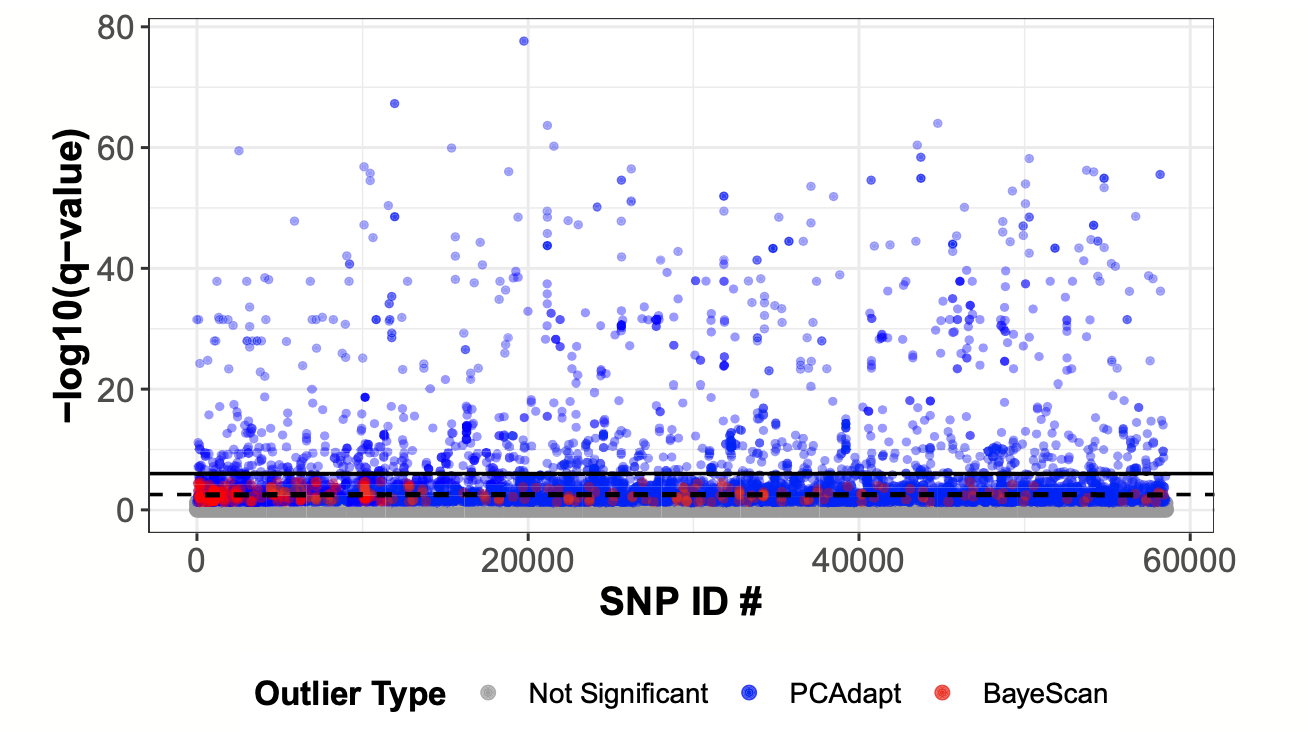

In [5]:
display_png(file="../figures/Fig5_original_Reich2021.png")

### Figure 5 from the paper
**Manhattan plot, taken directly from Reich et al. (2021). See the figure below for our manhattan plot.**

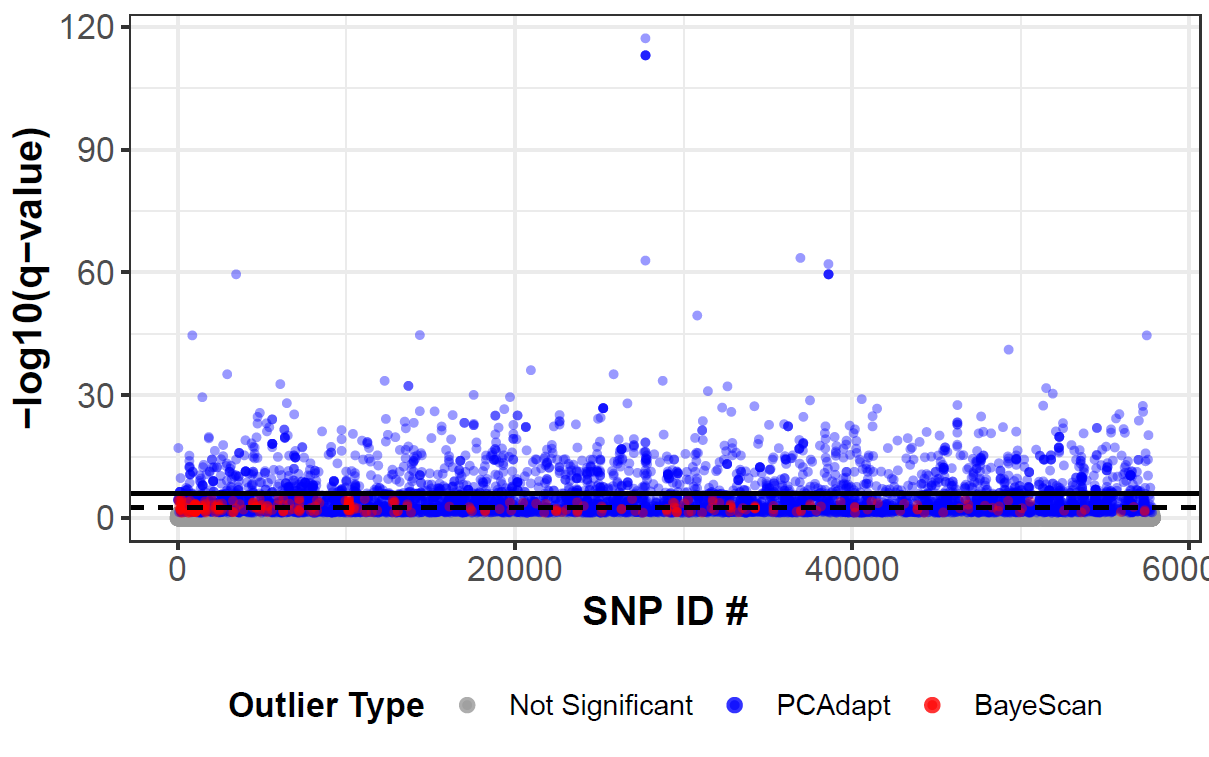

In [6]:
display_png(file='../figures/Fig_5_manhattanplot_total.png')

### Re-created Figure 5
**This is the output from our analysis of SNP outliers. To better understand the differences between our analysis and the authors, refer to the table at the beginning of the notebook or the written analysis above.**